In [2]:
from IPython.core.display import Markdown
import pandas as pd
import numpy as np
import datetime as dt
import time
import pickle
import os
cwd=os.getcwd()
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss,f1_score, recall_score
import seaborn as sb
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
customer_data = pd.read_csv("customer_data.csv")

To remove: UPGRADE_SALE_DT	BAGGAGE_SALE_DT	SEATING_SALE_DT	TVL_CBN_CDB; BKG_ORDER_ID; PARTY_IDF; unnamed; , ; Don't worry about cleaning data

### Feature that are incilliaries: P4S_TARGET BAGGAGE_TARGET, UPG_TARGET, HBO_IND 

Assumption - more baggage cuz more childern;
Business trip, maybe an upgrade cuz company card but no more upgrades

Redemption: not bought through cash, but because of delayed 

Economy: M, Y, O
World traveller plus - W
Club Europe - C
Club World - J
First - F

#### Cleaning the data 

In [4]:
# Getting rid of unnecessary columns such as the ones pinpointed in the powerpoint and also 
customer_data = customer_data.drop(columns = ["UPGRADE_SALE_DT", "BAGGAGE_SALE_DT", "SEATING_SALE_DT", "TVL_CBN_CD", "BKG_ORDER_ID", "PARTY_ID", "Unnamed: 0"])

# Stripping whitespaces from each column in the dataframe
def strip_df(df):
    '''
    Given a df, return a copy of the dataframe
    with whitespace removed from the front and back 
    of each entry.
    '''
    df_copy = deepcopy(df)
    
    for col_name in list(df.columns):
        if df_copy[col_name].dtype == 'object':
            df_copy[col_name] = df_copy[col_name].apply(lambda x: x.strip() if isinstance(x, str) else x)
    
    return df_copy
customer_data = strip_df(customer_data)


# getting rid of invalid data
customer_data.drop(customer_data.index[customer_data['BKD_CBN_CD'] == '  '], inplace=True)
customer_data.dropna(inplace = True)


# Setting features to categorical
categorical_features = ["FURTHEST_STN_CD", "ROUTE_GROUP", "BUS_LEIS_IND", "jny_typ", "JNY_CAT", "POS", "MKTG_AREA", "MKTG_REGION", "BKG_CHANNEL", "EC_TIER", "BKD_CBN_CD", "BAH_INDICATOR"]
customer_data[categorical_features] = customer_data[categorical_features].astype("category")

# Setting features to numerical datetype
datetype_features = ["BKG_DT", "FIRST_FLT_DT", "FINAL_FLT_DT"]
for column in datetype_features:
    customer_data[column] = pd.to_datetime(customer_data[column], format='%m/%d/%Y')

# Performing one hot encoding 
customer_data['LONG_HAUL_IND'] = customer_data['LONG_HAUL_IND'].replace(['Y','N'],[1,0])
customer_data['SATURDAY_NIGHT_STAY_IND'] = customer_data['SATURDAY_NIGHT_STAY_IND'].replace(['Y','N'],[1,0])
customer_data['REDEMPTION_BOOKING_IND'] = customer_data['REDEMPTION_BOOKING_IND'].replace(['Y','N'],[1,0])


# Function to standardise a column
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

customer_data["L36M_REVENUE"] = min_max_scaling(customer_data["L36M_REVENUE"])


# One hot encoding data using dummies
customer_data = pd.get_dummies(customer_data, columns=['ROUTE_GROUP','BUS_LEIS_IND','EC_TIER','BKD_CBN_CD','MKTG_REGION','BKG_CHANNEL', 'BAH_INDICATOR'])

# Getting rid of these features temporarily
customer_data = customer_data.drop(columns=["FURTHEST_STN_CD", "jny_typ", "JNY_CAT", "POS", "MKTG_AREA", "HBO_IND", "BKG_DT", "FIRST_FLT_DT", "FINAL_FLT_DT", ])


# Grouping the Gold tiers together
customer_data['EC_TIER_Gold'] = customer_data[['EC_TIER_Gold', 'EC_TIER_Gold For Life', 'EC_TIER_Gold Guest List', 'EC_TIER_Gold Guest List For Life']].any(axis=1)
customer_data.drop(columns=['EC_TIER_Gold For Life', 'EC_TIER_Gold Guest List', 'EC_TIER_Gold Guest List For Life'], inplace=True)


/tmp/ipykernel_23073/4028584798.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_data['LONG_HAUL_IND'] = customer_data['LONG_HAUL_IND'].replace(['Y','N'],[1,0])
/tmp/ipykernel_23073/4028584798.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_data['SATURDAY_NIGHT_STAY_IND'] = customer_data['SATURDAY_NIGHT_STAY_IND'].replace(['Y','N'],[1,0])
/tmp/ipykernel_23073/4028584798.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavio

In [5]:
customer_data.columns

Index(['ADULT_CNT', 'CHILD_CNT', 'INFANT_CNT', 'LONG_HAUL_IND',
       'SATURDAY_NIGHT_STAY_IND', 'REDEMPTION_BOOKING_IND', 'P4S_TARGET',
       'BAGGAGE_TARGET', 'UPG_TARGET', 'DURATION', 'DAYS_TO_DEPARTURE',
       'PREV_UPG_IND', 'PREV_BAGGAGE_IND', 'PREV_P4S_IND', 'L36M_REVENUE',
       'ROUTE_GROUP_APAC', 'ROUTE_GROUP_Canada & Mexico',
       'ROUTE_GROUP_Caribbean', 'ROUTE_GROUP_Indian Ocean',
       'ROUTE_GROUP_LCY_Business', 'ROUTE_GROUP_LCY_Leisure',
       'ROUTE_GROUP_LCY_Regions', 'ROUTE_GROUP_Middle East',
       'ROUTE_GROUP_New York', 'ROUTE_GROUP_Rest OF Africa',
       'ROUTE_GROUP_Rest of Africa', 'ROUTE_GROUP_SH-Business',
       'ROUTE_GROUP_SH-Connectors', 'ROUTE_GROUP_SH-Multi',
       'ROUTE_GROUP_SH-Multi Low Biz', 'ROUTE_GROUP_SH-Peak Holidays',
       'ROUTE_GROUP_South Africa', 'ROUTE_GROUP_South America',
       'ROUTE_GROUP_South Asia', 'ROUTE_GROUP_Target', 'ROUTE_GROUP_UA Hubs',
       'ROUTE_GROUP_USA Other', 'ROUTE_GROUP_VS/DL Hubs', 'BUS_LEIS_IND_B',


Checking to see if there is any other invalid data in the columns

In [47]:
for column in customer_data.columns:
    if column not in ["BKG_DT", "FIRST_FLT_DT", "FINAL_FLT_DT"]:
        if customer_data[column].dtype == "category":
            print(f"Column is: {column}")
            print(customer_data[column].unique().tolist())

Column is: FURTHEST_STN_CD
['LIN', 'DXB', 'EDI', 'AUH', 'TXL', 'ATH', 'LIS', 'JFK', 'FAO', 'CPH', 'SKG', 'PMI', 'YYZ', 'GVA', 'IST', 'CPT', 'AMS', 'GLA', 'BIO', 'JTR', 'TFS', 'HER', 'NQY', 'PSA', 'OSL', 'ACC', 'BLQ', 'MAA', 'VLC', 'SIN', 'TIA', 'DLM', 'DME', 'MRU', 'IAH', 'ABZ', 'LYS', 'BSL', 'BEY', 'BOM', 'LCA', 'HYD', 'MAN', 'AGP', 'LUX', 'BLR', 'PRG', 'CDG', 'MIA', 'IBZ', 'ZRH', 'BGI', 'WAW', 'BHD', 'NBO', 'JER', 'VCE', 'ATL', 'TPA', 'PIT', 'DUS', 'INN', 'BOD', 'FNC', 'SAN', 'MCO', 'KRK', 'MUC', 'TLV', 'MAD', 'BCN', 'KLX', 'SFO', 'DOH', 'HAM', 'OPO', 'DUB', 'LAS', 'JNB', 'PMO', 'TRN', 'LAX', 'SEA', 'ACE', 'UVF', 'SVQ', 'BUD', 'DEL', 'HEL', 'NCE', 'STR', 'RHO', 'HND', 'SPU', 'GOT', 'DUR', 'BRU', 'MEX', 'KUL', 'MRS', 'DEN', 'CFU', 'BKK', 'OTP', 'FRA', 'BOS', 'MLE', 'PUJ', 'OLB', 'NAP', 'SVO', 'ZAG', 'AUS', 'FCO', 'SEZ', 'CTA', 'BLL', 'JED', 'NCL', 'TAB', 'BRI', 'ORD', 'RTM', 'MSY', 'ARN', 'NAS', 'LOS', 'CUN', 'ALC', 'GOA', 'PHX', 'CAG', 'SJO', 'INV', 'PEK', 'BER', 'SOF', 'FLR', 'GCI',

Checking if there are any columns with np.nan data

In [4]:
customer_data.isna().any()

ADULT_CNT                       False
CHILD_CNT                       False
INFANT_CNT                      False
LONG_HAUL_IND                   False
SATURDAY_NIGHT_STAY_IND         False
                                ...  
BKG_CHANNEL_Indirect Leisure    False
BKG_CHANNEL_OTHER               False
BAH_INDICATOR_BAH               False
BAH_INDICATOR_Flight Only       False
EC_TIER_GOLD                    False
Length: 72, dtype: bool

#### Trying to find any linear correlations between the numerical columns

Getting rid of all of the columns which only have discrete data

In [50]:
customer_data.dtypes

FURTHEST_STN_CD                  category
ROUTE_GROUP                      category
BUS_LEIS_IND                     category
ADULT_CNT                           int64
CHILD_CNT                           int64
INFANT_CNT                          int64
LONG_HAUL_IND                       int64
SATURDAY_NIGHT_STAY_IND             int64
REDEMPTION_BOOKING_IND              int64
jny_typ                          category
JNY_CAT                          category
POS                              category
MKTG_AREA                        category
MKTG_REGION                      category
BKG_CHANNEL                      category
EC_TIER                          category
BKD_CBN_CD                       category
P4S_TARGET                          int64
BAGGAGE_TARGET                      int64
UPG_TARGET                          int64
HBO_IND                             int64
BKG_DT                     datetime64[ns]
FIRST_FLT_DT               datetime64[ns]
FINAL_FLT_DT               datetim

In [51]:
columns_to_drop = []
for i in range(len(customer_data.columns)):
    if customer_data.dtypes[i] == 'category':
        columns_to_drop.append(customer_data.columns[i])

customer_data_numerical = customer_data.drop(columns=columns_to_drop)

C:\Users\micha\AppData\Local\Temp\ipykernel_5140\1791057122.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if customer_data.dtypes[i] == 'category':
C:\Users\micha\AppData\Local\Temp\ipykernel_5140\1791057122.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if customer_data.dtypes[i] == 'category':
C:\Users\micha\AppData\Local\Temp\ipykernel_5140\1791057122.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if customer_data

C:\Users\micha\AppData\Local\Temp\ipykernel_5140\985675033.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


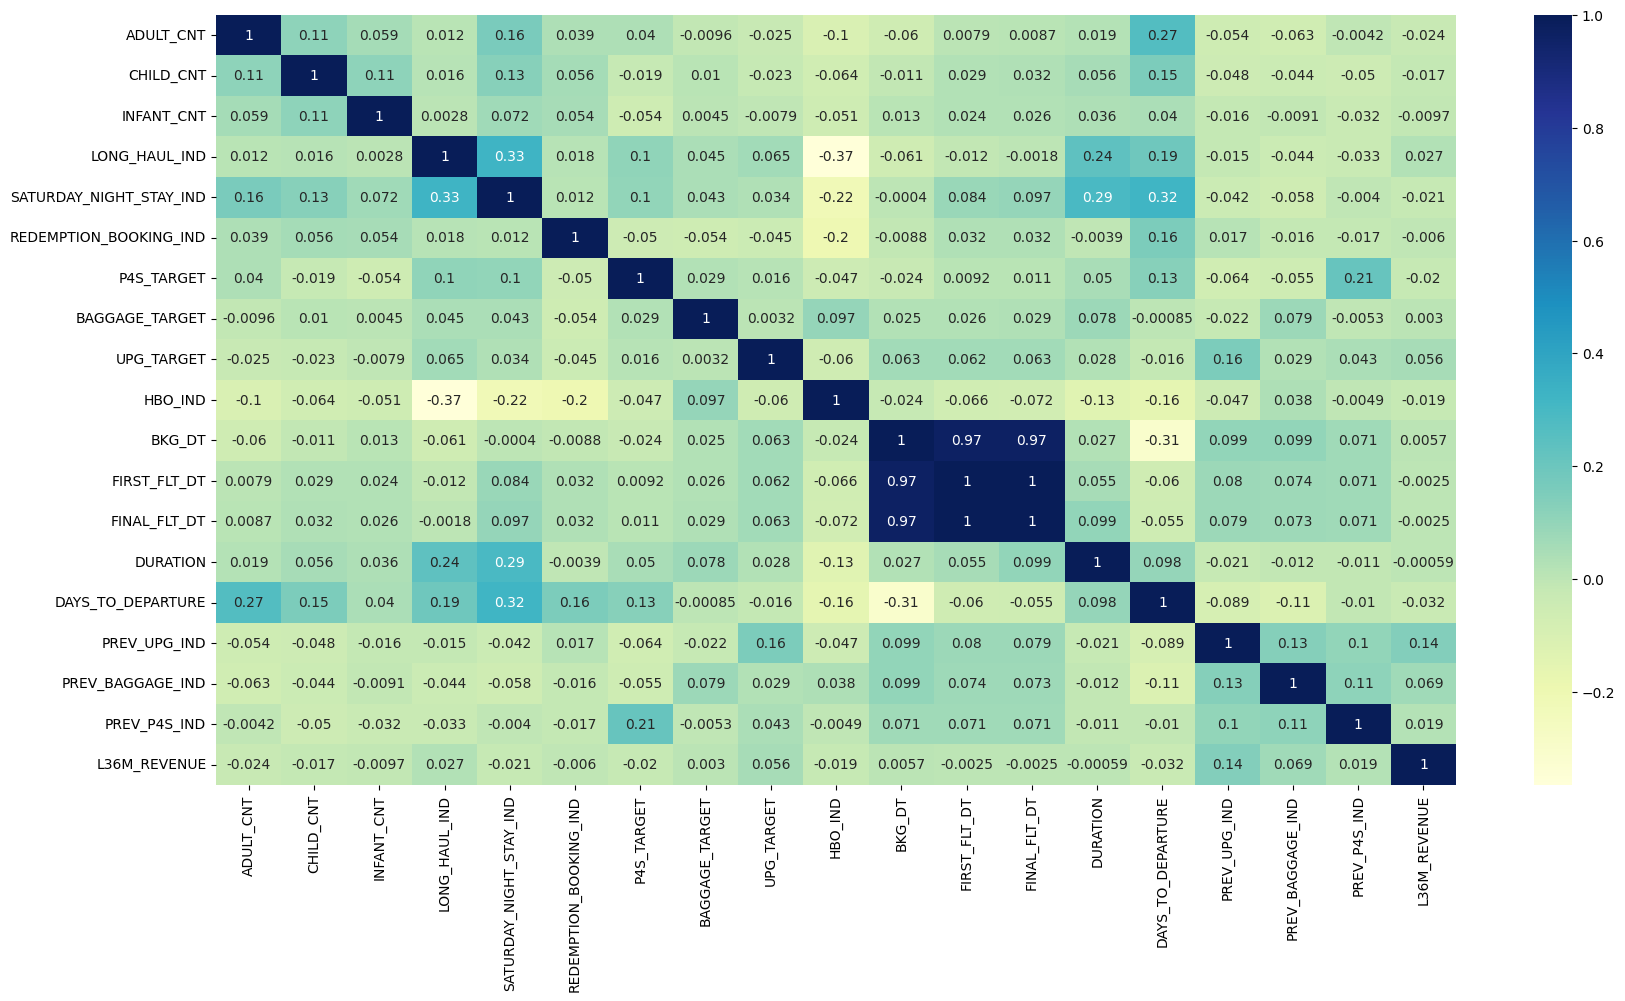

In [52]:

fig, ax = plt.subplots(figsize = (20, 10))
dataplot = sb.heatmap(customer_data_numerical.corr(), cmap = "YlGnBu", annot=True)
fig.show()

In [6]:
x = customer_data.drop(columns=["BAGGAGE_TARGET", "P4S_TARGET", "UPG_TARGET"])
y = customer_data[["BAGGAGE_TARGET", "P4S_TARGET", "UPG_TARGET"]]

# Stratify parameter just ensures that we get the same proportion of each of the y-data in the train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify=y)


In [5]:
imbalance_baggage = len(customer_data[(customer_data['BAGGAGE_TARGET'] == 1)])/len(customer_data)
imbalance_p4s = len(customer_data[(customer_data['P4S_TARGET'] == 1)])/len(customer_data)
imbalance_upgrade = len(customer_data[(customer_data['UPG_TARGET'] == 1)])/len(customer_data)
print('Baggage:',imbalance_baggage)
print('Pay for seating:',imbalance_p4s)
print('Upgrade:',imbalance_upgrade)

Baggage: 0.04084041825466628
Pay for seating: 0.1099032541776605
Upgrade: 0.032526140916642236


Showing the pie charts of the 3 y variables

In [ ]:
def show_distrib_y_data(column_name):
    count = ""
    count = customer_data[column_name].value_counts()

    count.plot(kind = 'pie', explode = [0, 0.1], 
        figsize = (6, 6), autopct = '%1.1f%%',
        colors = ['red', 'green'])
    plt.ylabel("Customers That Upgraded Booking")
    plt.legend(["Did Not Upgrade Booking", "Upgraded Booking"])
    plt.show()


# Visualize the proportion of borrowers
show_distrib_y_data("UPG_TARGET")

### Scale l36m revenue between 0 and 1

In [16]:
pd.set_option('display.max_columns', None )
x

,ADULT_CNT,CHILD_CNT,INFANT_CNT,LONG_HAUL_IND,SATURDAY_NIGHT_STAY_IND,REDEMPTION_BOOKING_IND,DURATION,DAYS_TO_DEPARTURE,PREV_UPG_IND,PREV_BAGGAGE_IND,PREV_P4S_IND,L36M_REVENUE,ROUTE_GROUP_APAC,ROUTE_GROUP_Canada & Mexico,ROUTE_GROUP_Caribbean,ROUTE_GROUP_Indian Ocean,ROUTE_GROUP_LCY_Business,ROUTE_GROUP_LCY_Leisure,ROUTE_GROUP_LCY_Regions,ROUTE_GROUP_Middle East,ROUTE_GROUP_New York,ROUTE_GROUP_Rest OF Africa,ROUTE_GROUP_Rest of Africa,ROUTE_GROUP_SH-Business,ROUTE_GROUP_SH-Connectors,ROUTE_GROUP_SH-Multi,ROUTE_GROUP_SH-Multi Low Biz,ROUTE_GROUP_SH-Peak Holidays,ROUTE_GROUP_South Africa,ROUTE_GROUP_South America,ROUTE_GROUP_South Asia,ROUTE_GROUP_Target,ROUTE_GROUP_UA Hubs,ROUTE_GROUP_USA Other,ROUTE_GROUP_VS/DL Hubs,BUS_LEIS_IND_B,BUS_LEIS_IND_L,BUS_LEIS_IND_U,EC_TIER_BARC,EC_TIER_Blue,EC_TIER_Bronze,EC_TIER_Gold,EC_TIER_Gold For Life,EC_TIER_Gold Guest List,EC_TIER_Gold Guest List For Life,EC_TIER_Leisure,EC_TIER_Non EC/BARC,EC_TIER_Premier,EC_TIER_Silver,BKD_CBN_CD_,BKD_CBN_CD_C,BKD_CBN_CD_F,BKD_CBN_CD_J,BKD_CBN_CD_M,BKD_CBN_CD_O,BKD_CBN_CD_W,BKD_CBN_CD_Y,MKTG_REGION_APMEA,MKTG_REGION_Americas,MKTG_REGION_Europe,MKTG_REGION_Spain,MKTG_REGION_UK and Ireland,BKG_CHANNEL_Direct,BKG_CHANNEL_Indirect Business,BKG_CHANNEL_Indirect Leisure,BKG_CHANNEL_OTHER,BAH_INDICATOR_BAH,BAH_INDICATOR_Flight Only
0,1,0,0,0,1,0,0,100,0,0,0,0.000029,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,2,0,0,1,1,1,7,415,0,1,1,0.000104,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,1,0,0,0,1,0,2,45,1,0,0,0.000071,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1
3,2,2,0,1,1,0,6,111,0,0,0,0.000029,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0
4,1,0,0,0,0,0,1,14,0,0,0,0.000124,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
5,1,0,0,0,0,0,1,4,0,0,0,0.000611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
6,1,0,0,0,1,0,5,24,0,0,1,0.000040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
7,1,0,0,1,0,0,6,37,0,0,0,0.000219,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
9,1,0,0,0,0,0,0,32,1,0,0,0.000528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
10,1,0,0,0,0,0,4,6,0,0,0,0.000039,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1


This worked before the customer_data df had the dummy variables, however, I copy pasted the pictures of the mosaic plots of a previous version of this Jupyter Notebook when this cell executed successfully to see the graphs that should have been shown

KeyError: 'EC_TIER'

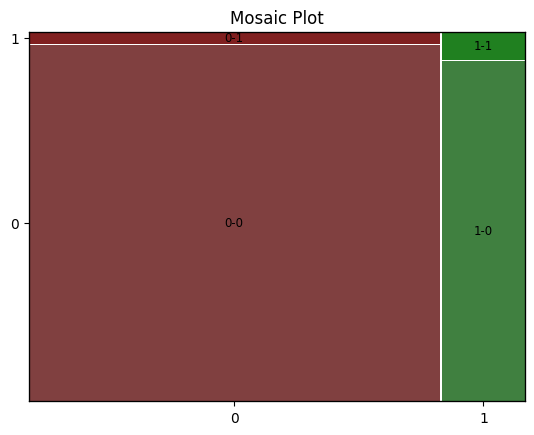

In [8]:
from statsmodels.graphics.mosaicplot import mosaic
# Function to generate custom labels
def labelizer(key):
    return f'{key[0]}-{key[1]}'

for x_column in ["PREV_BAGGAGE_IND", "EC_TIER", "BKD_CBN_CD", "jny_typ", "BKG_CHANNEL"]:
    for y_column in ["BAGGAGE_TARGET"]:
        # Creating a contingency table
        contingency_table = pd.crosstab(x[x_column], y[y_column])

        # Plotting the mosaic plot
        mosaic(contingency_table.stack(), title='Mosaic Plot', labelizer=labelizer)

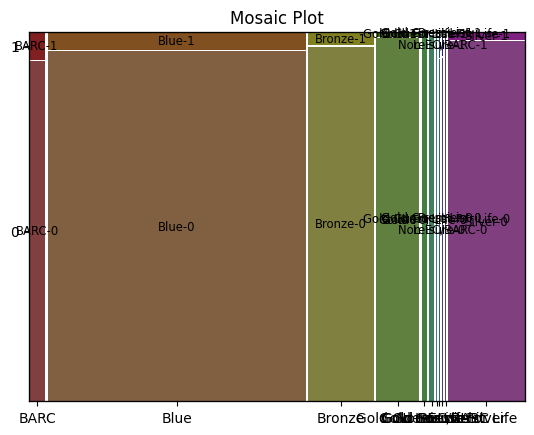

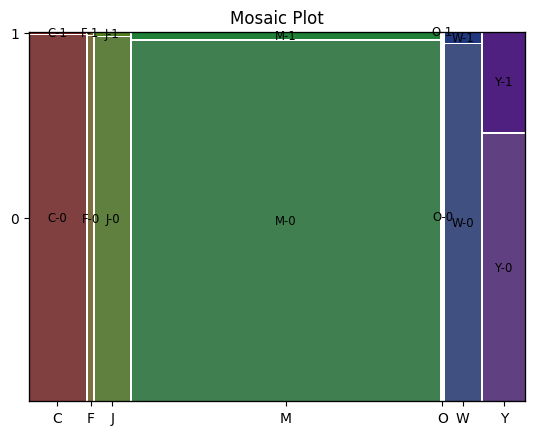

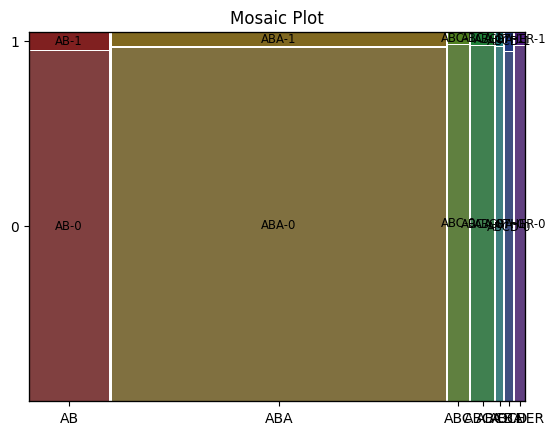

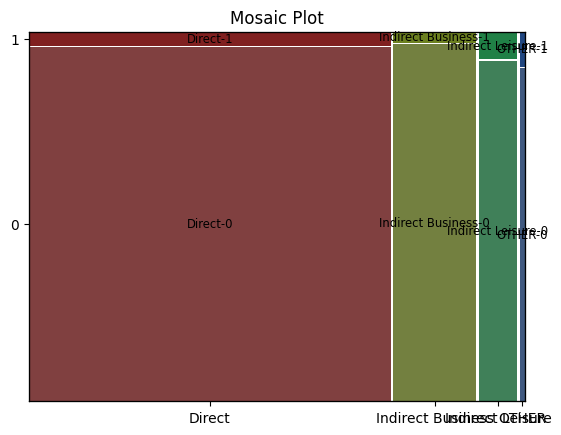

In [9]:
temp_df = customer_data[customer_data["BUS_LEIS_IND"] != "U"]

KeyError: 'BUS_LEIS_IND'

In [ ]:
for x_column in ["BUS_LEIS_IND"]:
    for y_column in ["BAGGAGE_TARGET"]:
        # Creating a contingency table
        contingency_table = pd.crosstab(temp_df[x_column], y[y_column])

        # Plotting the mosaic plot
        mosaic(contingency_table.stack(), title='Mosaic Plot')

## Modelling

In [7]:
def f1(y_true,y_pred):
    f1=f1_score(y_true, y_pred)
    print(f'F1 Score:{f1}')
    return f1

def recall(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    print(f'Recall Score: {recall}')
    return recall

def f1_and_recall(y_true, y_pred):
    f1=f1_score(y_true, y_pred)
    print(f'F1 Score:{f1}')
    recall = recall_score(y_true, y_pred)
    print(f'Recall Score: {recall}')
    return f1, recall

### Using XGB

Paid for seating

In [8]:
features = x_train.columns
features_p4s = features
run_features_XGB_p4s = []
run_scores_XGB_p4s = []

for r in range(len(features)):
    model_p4s = XGBClassifier(scale_pos_weight = 1/imbalance_p4s)
    trained_model_p4s = model_p4s.fit(x_train[features_p4s], y_train['P4S_TARGET'])
    XGB_model_predicted_p4s = trained_model_p4s.predict(x_test[features_p4s], )
    p4s_score = f1_and_recall(y_true=y_test['P4S_TARGET'],y_pred=XGB_model_predicted_p4s)
    run_features_XGB_p4s.append(features_p4s)
    run_scores_XGB_p4s.append(p4s_score)
    feature_importances = trained_model_p4s.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_p4s)[indices][1:]
    features_p4s = new_features
print('Model trained!')

F1 Score:0.5574280693582876
Recall Score: 0.9364085784400896
F1 Score:0.5574280693582876
Recall Score: 0.9364085784400896
F1 Score:0.5574280693582876
Recall Score: 0.9364085784400896
F1 Score:0.5574527093543914
Recall Score: 0.9364797097841163
F1 Score:0.5574457724188306
Recall Score: 0.9364085784400896
F1 Score:0.557220463185539
Recall Score: 0.9357328306718355
F1 Score:0.5561766823360014
Recall Score: 0.9341679411032472
F1 Score:0.557416699375179
Recall Score: 0.9344169008073407
F1 Score:0.5582820135039166
Recall Score: 0.9366219724721698
F1 Score:0.5577958699062884
Recall Score: 0.9356972649998222
F1 Score:0.5575869341727343
Recall Score: 0.9355550023117687
F1 Score:0.5575550630428098
Recall Score: 0.9349859515595548
F1 Score:0.5566724510094384
Recall Score: 0.9355550023117687
F1 Score:0.5578164929432597
Recall Score: 0.9354838709677419
F1 Score:0.5572453554055343
Recall Score: 0.9350215172315681
F1 Score:0.5578565826568032
Recall Score: 0.9360173560479426
F1 Score:0.557927087749046

Finding the max score

In [9]:
max = 0
for i in range(len(run_scores_XGB_p4s)):
    if max <= 0.3 * run_scores_XGB_p4s[i][0] + run_scores_XGB_p4s[i][1] * 0.7:
        max =  0.3 * run_scores_XGB_p4s[i][0] + run_scores_XGB_p4s[i][1] * 0.7
        print(run_features_XGB_p4s[i])
        print(run_scores_XGB_p4s[i])

Index(['ADULT_CNT', 'CHILD_CNT', 'INFANT_CNT', 'LONG_HAUL_IND',
       'SATURDAY_NIGHT_STAY_IND', 'REDEMPTION_BOOKING_IND', 'DURATION',
       'DAYS_TO_DEPARTURE', 'PREV_UPG_IND', 'PREV_BAGGAGE_IND', 'PREV_P4S_IND',
       'L36M_REVENUE', 'ROUTE_GROUP_APAC', 'ROUTE_GROUP_Canada & Mexico',
       'ROUTE_GROUP_Caribbean', 'ROUTE_GROUP_Indian Ocean',
       'ROUTE_GROUP_LCY_Business', 'ROUTE_GROUP_LCY_Leisure',
       'ROUTE_GROUP_LCY_Regions', 'ROUTE_GROUP_Middle East',
       'ROUTE_GROUP_New York', 'ROUTE_GROUP_Rest OF Africa',
       'ROUTE_GROUP_Rest of Africa', 'ROUTE_GROUP_SH-Business',
       'ROUTE_GROUP_SH-Connectors', 'ROUTE_GROUP_SH-Multi',
       'ROUTE_GROUP_SH-Multi Low Biz', 'ROUTE_GROUP_SH-Peak Holidays',
       'ROUTE_GROUP_South Africa', 'ROUTE_GROUP_South America',
       'ROUTE_GROUP_South Asia', 'ROUTE_GROUP_Target', 'ROUTE_GROUP_UA Hubs',
       'ROUTE_GROUP_USA Other', 'ROUTE_GROUP_VS/DL Hubs', 'BUS_LEIS_IND_B',
       'BUS_LEIS_IND_L', 'BUS_LEIS_IND_U', 'EC_TIER_B

In [31]:
model_max_p4s.feature_importances_

array([0.00871393, 0.00882737, 0.00815135, 0.01073156, 0.02318165,
       0.02710751, 0.0269031 , 0.02874283, 0.03838953, 0.10297853,
       0.1197407 , 0.11012839, 0.19190703, 0.2944965 ], dtype=float32)

In [13]:
max_p4s=['BKG_CHANNEL_Indirect Business', 'REDEMPTION_BOOKING_IND', 'BUS_LEIS_IND_B',
 'EC_TIER_Bronze', 'INFANT_CNT', 'BKD_CBN_CD_F', 'PREV_P4S_IND',
 'EC_TIER_BARC', 'EC_TIER_Blue', 'EC_TIER_Silver', 'EC_TIER_Gold',
 'BKD_CBN_CD_M', 'LONG_HAUL_IND', 'BKD_CBN_CD_Y']

model_max_p4s = XGBClassifier(scale_pos_weight = 1/imbalance_p4s)
trained_model_max_p4s = model_max_p4s.fit(x_train[max_p4s], y_train['P4S_TARGET'])
XGB_model_predicted_max_p4s = trained_model_max_p4s.predict(x_test[max_p4s], )
max_p4s_score = f1_and_recall(y_true=y_test['P4S_TARGET'],y_pred=XGB_model_predicted_max_p4s)

F1 Score:0.5156971287375256
Recall Score: 0.957534587616033


/tmp/ipykernel_23073/3770530957.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['0', '1'])
/tmp/ipykernel_23073/3770530957.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['0', '1'])


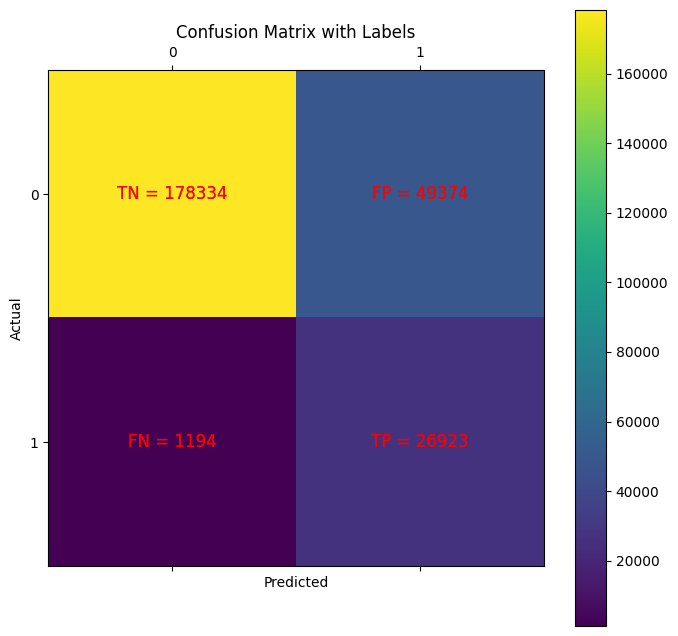

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
 

confusion_matrix = metrics.confusion_matrix(y_test['P4S_TARGET'], XGB_model_predicted_max_p4s)

TN, FP, FN, TP = confusion_matrix.ravel()
# You might need to adjust the coordinates if they do not fit your matrix
ax.text(0, 0, f'TN = {TN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 0, f'FP = {FP}', ha='center', va='center', color='red', fontsize=12)
ax.text(0, 1, f'FN = {FN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 1, f'TP = {TP}', ha='center', va='center', color='red', fontsize=12)

cax = ax.matshow(confusion_matrix, )

# Adding color bar
plt.colorbar(cax)

# Adding labels
ax.set_xticklabels([''] + ['0', '1'])
ax.set_yticklabels([''] + ['0', '1'])

# Adding title and labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Labels')

# Extracting values for annotation
TN, FP, FN, TP = confusion_matrix.ravel()

# Adding the text annotations
for (i, j), val in np.ndenumerate(confusion_matrix):
    if (i, j) == (0, 0):
        text = f'TN = {TN}'
    elif (i, j) == (0, 1):
        text = f'FP = {FP}'
    elif (i, j) == (1, 0):
        text = f'FN = {FN}'
    elif (i, j) == (1, 1):
        text = f'TP = {TP}'
    
    ax.text(j, i, text, ha='center', va='center', color='red', fontsize=12)

plt.show()


In [ ]:
features = x_train.columns
features_p4s = features
run_features_XGB_p4s = []
run_scores_XGB_p4s = []

for r in range(len(features)):
    model_p4s = XGBClassifier(scale_pos_weight = 1/imbalance_p4s)
    trained_model_p4s = model_p4s.fit(x_train[features_p4s], y_train['P4S_TARGET'])
    XGB_model_predicted_p4s = trained_model_p4s.predict(x_test[features_p4s], )
    p4s_score = f1_and_recall(y_true=y_test['P4S_TARGET'],y_pred=XGB_model_predicted_p4s)
    run_features_XGB_p4s.append(features_p4s)
    run_scores_XGB_p4s.append(p4s_score)
    feature_importances = trained_model_p4s.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_p4s)[indices][1:]
    features_p4s = new_features
print('Model trained!')

### XGB baggage

In [16]:
features = x_train.columns
features_baggage = features
run_features_XGB_baggage = []
run_scores_XGB_baggage = []

for r in range(len(features)):
    model_baggage = XGBClassifier(scale_pos_weight = 1/imbalance_baggage)
    trained_model_baggage = model_baggage.fit(x_train[features_baggage], y_train['BAGGAGE_TARGET'])
    XGB_model_predicted_baggage = trained_model_baggage.predict(x_test[features_baggage], )
    baggage_score = f1_and_recall(y_true=y_test['BAGGAGE_TARGET'],y_pred=XGB_model_predicted_baggage)
    run_features_XGB_baggage.append(features_baggage)
    run_scores_XGB_baggage.append(baggage_score)
    feature_importances = trained_model_baggage.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_baggage)[indices][1:]
    features_baggage = new_features
print('Model trained!')

F1 Score:0.31609519699936933
Recall Score: 0.9114663093415007
F1 Score:0.31610044313146235
Recall Score: 0.9114663093415007
F1 Score:0.31610044313146235
Recall Score: 0.9114663093415007
F1 Score:0.31610044313146235
Recall Score: 0.9114663093415007
F1 Score:0.3151543281503829
Recall Score: 0.9098392036753445
F1 Score:0.31548033847685414
Recall Score: 0.9099349157733537
F1 Score:0.31505850376213995
Recall Score: 0.9097434915773354
F1 Score:0.31711297628563817
Recall Score: 0.9112748851454824
F1 Score:0.3155432420326161
Recall Score: 0.9102220520673813
F1 Score:0.3161058889959146
Recall Score: 0.9108920367534457
F1 Score:0.31647362719773353
Recall Score: 0.9087863705972435
F1 Score:0.31534373962138823
Recall Score: 0.9087863705972435
F1 Score:0.31625723986419013
Recall Score: 0.9093606431852986
F1 Score:0.3156373542407229
Recall Score: 0.9093606431852986
F1 Score:0.3165798192018912
Recall Score: 0.9100306278713629
F1 Score:0.31555836465852766
Recall Score: 0.9079249617151608
F1 Score:0.31

In [17]:
max = 0
for i in range(len(run_scores_XGB_baggage)):
    if max <= 0.3 * run_scores_XGB_baggage[i][0] + run_scores_XGB_baggage[i][1] * 0.7:
        max =  0.3 * run_scores_XGB_baggage[i][0] + run_scores_XGB_baggage[i][1] * 0.7
        print(run_features_XGB_baggage[i])
        print(run_scores_XGB_baggage[i])

Index(['ADULT_CNT', 'CHILD_CNT', 'INFANT_CNT', 'LONG_HAUL_IND',
       'SATURDAY_NIGHT_STAY_IND', 'REDEMPTION_BOOKING_IND', 'DURATION',
       'DAYS_TO_DEPARTURE', 'PREV_UPG_IND', 'PREV_BAGGAGE_IND', 'PREV_P4S_IND',
       'L36M_REVENUE', 'ROUTE_GROUP_APAC', 'ROUTE_GROUP_Canada & Mexico',
       'ROUTE_GROUP_Caribbean', 'ROUTE_GROUP_Indian Ocean',
       'ROUTE_GROUP_LCY_Business', 'ROUTE_GROUP_LCY_Leisure',
       'ROUTE_GROUP_LCY_Regions', 'ROUTE_GROUP_Middle East',
       'ROUTE_GROUP_New York', 'ROUTE_GROUP_Rest OF Africa',
       'ROUTE_GROUP_Rest of Africa', 'ROUTE_GROUP_SH-Business',
       'ROUTE_GROUP_SH-Connectors', 'ROUTE_GROUP_SH-Multi',
       'ROUTE_GROUP_SH-Multi Low Biz', 'ROUTE_GROUP_SH-Peak Holidays',
       'ROUTE_GROUP_South Africa', 'ROUTE_GROUP_South America',
       'ROUTE_GROUP_South Asia', 'ROUTE_GROUP_Target', 'ROUTE_GROUP_UA Hubs',
       'ROUTE_GROUP_USA Other', 'ROUTE_GROUP_VS/DL Hubs', 'BUS_LEIS_IND_B',
       'BUS_LEIS_IND_L', 'BUS_LEIS_IND_U', 'EC_TIER_B

In [36]:
model_max_baggage.feature_importances_

array([0.00703028, 0.00636759, 0.00663236, 0.00988917, 0.02248205,
       0.01991337, 0.02335577, 0.06578868, 0.29066458, 0.5478761 ],
      dtype=float32)

Creating the  most optimal model for XGB Baggage

In [35]:
max_baggage=['REDEMPTION_BOOKING_IND', 'DURATION', 'EC_TIER_Gold', 'BKD_CBN_CD_W',
 'BAH_INDICATOR_BAH', 'PREV_BAGGAGE_IND', 'ROUTE_GROUP_Rest OF Africa',
 'BKD_CBN_CD_M', 'LONG_HAUL_IND', 'BKD_CBN_CD_Y']

model_max_baggage = XGBClassifier(scale_pos_weight = 1/imbalance_baggage)
trained_model_max_baggage = model_max_baggage.fit(x_train[max_baggage], y_train['BAGGAGE_TARGET'])
XGB_model_predicted_max_baggage = trained_model_max_baggage.predict(x_test[max_baggage], )
max_baggage_score = f1_and_recall(y_true=y_test['BAGGAGE_TARGET'],y_pred=XGB_model_predicted_max_baggage)

F1 Score:0.2815022308214332
Recall Score: 0.9330015313935681


#### Confusoin matrix for XGB baggage

/tmp/ipykernel_23073/4291960280.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['0', '1'])
/tmp/ipykernel_23073/4291960280.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['0', '1'])


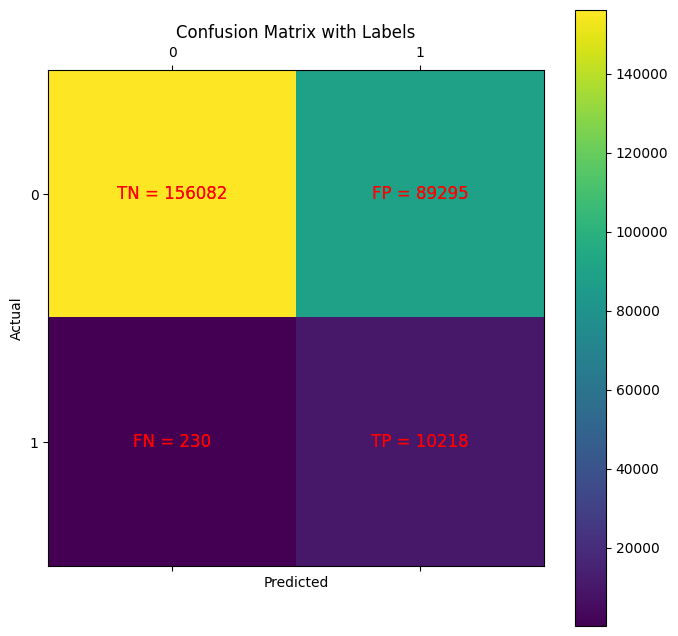

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
 

confusion_matrix = metrics.confusion_matrix(y_test['BAGGAGE_TARGET'], XGB_model_predicted_max_baggage)

TN, FP, FN, TP = confusion_matrix.ravel()
# You might need to adjust the coordinates if they do not fit your matrix
ax.text(0, 0, f'TN = {TN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 0, f'FP = {FP}', ha='center', va='center', color='red', fontsize=12)
ax.text(0, 1, f'FN = {FN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 1, f'TP = {TP}', ha='center', va='center', color='red', fontsize=12)

cax = ax.matshow(confusion_matrix, )

# Adding color bar
plt.colorbar(cax)

# Adding labels
ax.set_xticklabels([''] + ['0', '1'])
ax.set_yticklabels([''] + ['0', '1'])

# Adding title and labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Labels')

# Extracting values for annotation
TN, FP, FN, TP = confusion_matrix.ravel()

# Adding the text annotations
for (i, j), val in np.ndenumerate(confusion_matrix):
    if (i, j) == (0, 0):
        text = f'TN = {TN}'
    elif (i, j) == (0, 1):
        text = f'FP = {FP}'
    elif (i, j) == (1, 0):
        text = f'FN = {FN}'
    elif (i, j) == (1, 1):
        text = f'TP = {TP}'
    
    ax.text(j, i, text, ha='center', va='center', color='red', fontsize=12)

plt.show()


### XGB UPGRADE

In [20]:
features = x_train.columns
features_upgrade = features
run_features_XGB_upgrade = []
run_scores_XGB_upgrade = []

for r in range(len(features)):
    model_upgrade = XGBClassifier(scale_pos_weight = 1/imbalance_upgrade)
    trained_model_upgrade = model_upgrade.fit(x_train[features_upgrade], y_train['UPG_TARGET'])
    XGB_model_predicted_upgrade = trained_model_upgrade.predict(x_test[features_upgrade], )
    upgrade_score = f1_and_recall(y_true=y_test['UPG_TARGET'],y_pred=XGB_model_predicted_upgrade)
    run_features_XGB_upgrade.append(features_upgrade)
    run_scores_XGB_upgrade.append(upgrade_score)
    feature_importances = trained_model_upgrade.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_upgrade)[indices][1:]
    features_upgrade = new_features
print('Model trained!')

F1 Score:0.24929511278195488
Recall Score: 0.8925609902655931
F1 Score:0.24929511278195488
Recall Score: 0.8925609902655931
F1 Score:0.24929511278195488
Recall Score: 0.8925609902655931
F1 Score:0.24929511278195488
Recall Score: 0.8925609902655931
F1 Score:0.24897336618561539
Recall Score: 0.8925609902655931
F1 Score:0.24933241522933006
Recall Score: 0.8920802788126427
F1 Score:0.24789410348977137
Recall Score: 0.8912390337699796
F1 Score:0.24925746312486366
Recall Score: 0.8925609902655931
F1 Score:0.24998319553673456
Recall Score: 0.8938829467612066
F1 Score:0.24961753778390464
Recall Score: 0.8922004566758803
F1 Score:0.2489406957075148
Recall Score: 0.8931618795817811
F1 Score:0.24922715053763442
Recall Score: 0.8913592116332172
F1 Score:0.2501765358619994
Recall Score: 0.8941233024876818
F1 Score:0.24955856386109476
Recall Score: 0.89171974522293
F1 Score:0.24852525860196187
Recall Score: 0.8936425910347314
F1 Score:0.24981507632304487
Recall Score: 0.8929215238553059
F1 Score:0.2

In [21]:
max = 0
for i in range(len(run_scores_XGB_upgrade)):
    if max <= 0.3 * run_scores_XGB_upgrade[i][0] + run_scores_XGB_upgrade[i][1] * 0.7:
        max =  0.3 * run_scores_XGB_upgrade[i][0] + run_scores_XGB_upgrade[i][1] * 0.7
        print(run_features_XGB_upgrade[i])
        print(run_scores_XGB_upgrade[i])

Index(['ADULT_CNT', 'CHILD_CNT', 'INFANT_CNT', 'LONG_HAUL_IND',
       'SATURDAY_NIGHT_STAY_IND', 'REDEMPTION_BOOKING_IND', 'DURATION',
       'DAYS_TO_DEPARTURE', 'PREV_UPG_IND', 'PREV_BAGGAGE_IND', 'PREV_P4S_IND',
       'L36M_REVENUE', 'ROUTE_GROUP_APAC', 'ROUTE_GROUP_Canada & Mexico',
       'ROUTE_GROUP_Caribbean', 'ROUTE_GROUP_Indian Ocean',
       'ROUTE_GROUP_LCY_Business', 'ROUTE_GROUP_LCY_Leisure',
       'ROUTE_GROUP_LCY_Regions', 'ROUTE_GROUP_Middle East',
       'ROUTE_GROUP_New York', 'ROUTE_GROUP_Rest OF Africa',
       'ROUTE_GROUP_Rest of Africa', 'ROUTE_GROUP_SH-Business',
       'ROUTE_GROUP_SH-Connectors', 'ROUTE_GROUP_SH-Multi',
       'ROUTE_GROUP_SH-Multi Low Biz', 'ROUTE_GROUP_SH-Peak Holidays',
       'ROUTE_GROUP_South Africa', 'ROUTE_GROUP_South America',
       'ROUTE_GROUP_South Asia', 'ROUTE_GROUP_Target', 'ROUTE_GROUP_UA Hubs',
       'ROUTE_GROUP_USA Other', 'ROUTE_GROUP_VS/DL Hubs', 'BUS_LEIS_IND_B',
       'BUS_LEIS_IND_L', 'BUS_LEIS_IND_U', 'EC_TIER_B

In [38]:
model_max_upgrade.feature_importances_

array([0.00618828, 0.00879025, 0.01638987, 0.04255661, 0.03028974,
       0.47843745, 0.41734773], dtype=float32)

In [37]:
max_upgrade=['BKD_CBN_CD_M', 'BKD_CBN_CD_F', 'BKD_CBN_CD_W', 'BKD_CBN_CD_J',
 'PREV_UPG_IND', 'LONG_HAUL_IND', 'BKD_CBN_CD_Y']

model_max_upgrade = XGBClassifier(scale_pos_weight = 1/imbalance_upgrade)
trained_model_max_upgrade = model_max_upgrade.fit(x_train[max_upgrade], y_train['UPG_TARGET'])
XGB_model_predicted_max_upgrade = trained_model_max_upgrade.predict(x_test[max_upgrade], )
max_upgrade_score = f1_and_recall(y_true=y_test['UPG_TARGET'],y_pred=XGB_model_predicted_max_upgrade)

F1 Score:0.18083150596938888
Recall Score: 0.9811320754716981


/tmp/ipykernel_23073/3409086121.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['0', '1'])
/tmp/ipykernel_23073/3409086121.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['0', '1'])


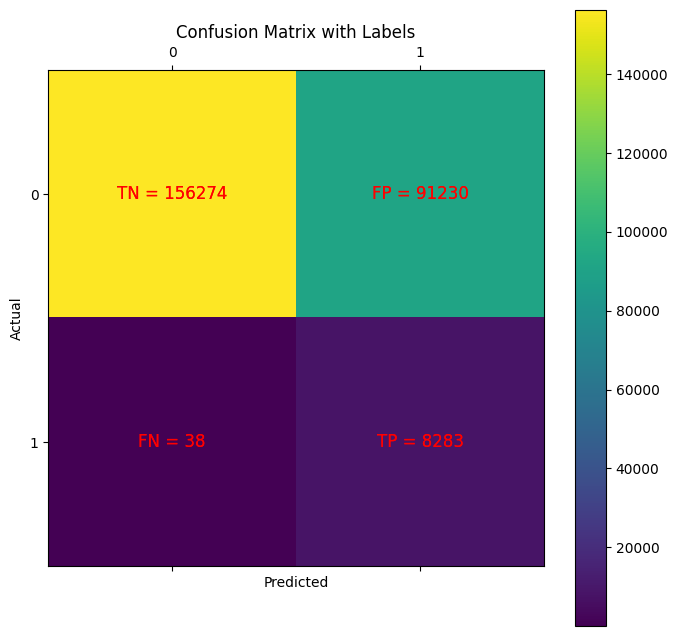

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
 

confusion_matrix = metrics.confusion_matrix(y_test['UPG_TARGET'], XGB_model_predicted_max_upgrade)

TN, FP, FN, TP = confusion_matrix.ravel()
# You might need to adjust the coordinates if they do not fit your matrix
ax.text(0, 0, f'TN = {TN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 0, f'FP = {FP}', ha='center', va='center', color='red', fontsize=12)
ax.text(0, 1, f'FN = {FN}', ha='center', va='center', color='red', fontsize=12)
ax.text(1, 1, f'TP = {TP}', ha='center', va='center', color='red', fontsize=12)

cax = ax.matshow(confusion_matrix, )

# Adding color bar
plt.colorbar(cax)

# Adding labels
ax.set_xticklabels([''] + ['0', '1'])
ax.set_yticklabels([''] + ['0', '1'])

# Adding title and labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Labels')

# Extracting values for annotation
TN, FP, FN, TP = confusion_matrix.ravel()

# Adding the text annotations
for (i, j), val in np.ndenumerate(confusion_matrix):
    if (i, j) == (0, 0):
        text = f'TN = {TN}'
    elif (i, j) == (0, 1):
        text = f'FP = {FP}'
    elif (i, j) == (1, 0):
        text = f'FN = {FN}'
    elif (i, j) == (1, 1):
        text = f'TP = {TP}'
    
    ax.text(j, i, text, ha='center', va='center', color='red', fontsize=12)

plt.show()


### Using SVM

In [14]:
features = ["BKD_CBN_CD_Y"]
features_p4s = features
run_features = []
run_scores = []

for r in range(len(features)):
    model_p4s = svm.SVC(kernel='linear', C=1.0)
    trained_model_p4s = model_p4s.fit(x_train[features_p4s], y_train['P4S_TARGET'])
    model_predicted_p4s = trained_model_p4s.predict(x_test[features_p4s], )
    p4s_score = recall(y_true=y_test['P4S_TARGET'],y_pred=model_predicted_p4s)
    run_features.append(features_p4s)
    run_scores.append(p4s_score)
    feature_importances = trained_model_p4s.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_p4s)[indices][1:]
    features_p4s = new_features
print('Model trained!')

### Using Random Forests (Issam is Certi)

In [20]:
features = x_train.columns
features_baggage = features
run_features_RF_baggage = []
run_scores_RF_baggage = []
for r in range(len(features)):
    model_baggage = RandomForestClassifier()
    trained_model_baggage = model_baggage.fit(x_train[features_baggage], y_train['BAGGAGE_TARGET'])
    RF_model_predicted_baggage = trained_model_baggage.predict(x_test[features_baggage], )
    baggage_score = f1_and_recall(y_true=y_test['BAGGAGE_TARGET'],y_pred=RF_model_predicted_baggage)
    run_features_RF_baggage.append(features_baggage)
    run_scores_RF_baggage.append(baggage_score)
    feature_importances = trained_model_baggage.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_baggage)[indices][1:]
    features_baggage = new_features
print('Model trained!')

In [15]:
features = ["L36M_REVENUE", "BKD_CBN_CD_Y"]
features_baggage= features
run_features = []
run_scores = []

for r in range(len(features)):
    model_baggage= XGBClassifier(scale_pos_weight = 1/imbalance_p4s)
    trained_model_baggage= model_p4s.fit(x_train[features_baggage], y_train['BAGGAGE_TARGET'])
    model_predicted_baggage= trained_model_p4s.predict(x_test[features_baggage], )
    p4s_score = recall(y_true=y_test['BAGGAGE_TARGET'],y_pred=model_predicted_p4s)
    run_features.append(features_baggage)
    run_scores.append(p4s_score)
    feature_importances = trained_model_p4s.feature_importances_
    indices = np.argsort(feature_importances)
    new_features = np.array(features_baggage)[indices][1:]
    features_baggage= new_features
print('Model trained!')

KeyboardInterrupt: 

In [33]:
run_scores

[0.8, 0.8]

#### TO DO:
Run a model on baggage based on descriptive analysis (corr matrix and mosaic graphs) (only on a few certain features, not all); ##### forget upgrade target
2 models built that build an answer (baggage and seating)
Start doing presentatation

Answer: estimate how many passengers would buy an ancillary, and say what the f1 score accuracy was

#### Show that in a confusion matrix (SEATING AND BAGGAGE)

Step 1: build baggage model (Random Forest)

Step 2: show results of paid for seating and baggage model in confusion matrix (with f1 score)

Step 3: Build the presentation

Step 4: If extra time(look at how XGB works and explain it to a non technical audience)

Step 5: Look at probability for XGB for seating (can be quite quick) (if extra time)

Step 6: Don't get distracted to fine tune a model when you don't have one for baggage (get an answer first as that is the most importnat thing)